In [0]:
'''
   Expectation Maximization on iris data
   Using a diagonal covariance matrix and not full covariance matrix
'''

import numpy as np
from matplotlib import pyplot as plt
import random
from scipy.interpolate import griddata
from matplotlib import cm
import copy

from sklearn import datasets
from sklearn import decomposition
import pdb
random.seed(0)            
    
#def gaussian_label(mu_actual,mu_predicted):

In [0]:

def get_iris_data():
    (X,Y) = datasets.load_iris(return_X_y=True)
    return X,Y

In [0]:
def generate_multivariate_gaussian_data(mean,cov,n):
    return np.random.multivariate_normal(mean,cov,n)

In [0]:
def initialize(x,n):
    mu = np.asarray(random.sample(list(x),n))
    sigma_inv = np.asarray([np.identity(x.shape[1]) for i in range(0,n)])
    prior_hidden = np.ones((n,1))*1.0/n 
    return mu,sigma_inv,prior_hidden

In [0]:
def plot_func(x,col):
    plt.scatter(x[:,0],x[:,1],color=col)

In [0]:
def mahalanobis_func(x,mu,sigma_inv):
    return [np.dot(np.dot((x-mu)[i],sigma_inv),(x-mu)[i].T) for i in range(0,x.shape[0])]    

In [0]:
# Part of E-step(Expectation step)
def un_prob_x_t(x,mu,sigma_inv,prior_hidden,q_proxy):
    
    mahalanobis = np.asarray([mahalanobis_func(x,mu[i],sigma_inv[i]) for i in range(0,len(mu))])
    try:
      e = np.exp((-0.5)*mahalanobis)
      sqrt_cov_inv_det = np.asarray([[np.sqrt(np.linalg.det(sigma_inv[i]))] for i in range(0,sigma_inv.shape[0])])
    except OverflowError:
      return q_proxy  
    except ZeroDivisionError:
      return q_proxy  
    e=(e*np.sqrt(sqrt_cov_inv_det))*prior_hidden
    return e

In [0]:
def E_step(x,mu,sigma_inv,prior_hidden,q_proxy):
    unor_prob_x_t = un_prob_x_t(x,mu,sigma_inv,prior_hidden,copy.deepcopy(q_proxy))
    q_proxy = [(unor_prob_x_t[:,i]/sum(unor_prob_x_t[:,i])) for i in range(0,x.shape[0])]
    return np.asarray(q_proxy)

In [0]:
# Part of M-step(Maximisation step)
def mu_update(x,mu,q_proxy):
    num = np.asarray([[sum((x*q_proxy[:,i:i+1])[:,j]) for j in range(0,x.shape[1])]for i in range(0,q_proxy.shape[1])])
    den = np.asarray([sum(q_proxy[:,i:i+1]) for i in range(0,q_proxy.shape[1])])
    try:
      mu_try = np.asarray([num[i,:]/den[i][0] for i in range(0,num.shape[0])]) 
    except ZeroDivisionError:
      return mu  
    mu=mu_try  
    return mu

In [0]:
#Part of M-step
def sigma_update(x,mu,sigma_inv,q_proxy):

    try:
      sigma_inv = [np.linalg.inv(np.dot((((x-mu[i])*q_proxy[:,i:i+1]).T),(x-mu[i]))) for i in range(0,len(mu))]
    except np.linalg.LinAlgError:
      return sigma_inv  
    den = [sum(q_proxy[:,j:j+1]) for j in range(0,q_proxy.shape[1])]
    sigma_inv = np.asarray([sigma_inv[i]*den[i] for i in range(len(den))])
    return sigma_inv

In [0]:
def prior_hidden_update(x,mu,q_proxy):
    return (1.0/q_proxy.shape[0])*np.asarray([sum(q_proxy[:,i:i+1]) for i in range(0,q_proxy.shape[1])])

In [0]:
def M_step(x,mu,sigma_inv,q_proxy):

    mu_new = mu_update(x,copy.deepcopy(mu),q_proxy)    
    sigma_inv_new = sigma_update(x,mu,copy.deepcopy(sigma_inv),q_proxy)
    prior_hidden_new = prior_hidden_update(x,mu,q_proxy)
    return mu_new,sigma_inv_new,prior_hidden_new

In [0]:
def mean(x,y):

    classes = set(y)
    mu = []
    for c in classes:
        mu.append(np.average(x[np.where(y==c)[0]],axis=0))
    return np.array(mu)

In [0]:
def PCA_projection(x):

    pca = decomposition.PCA(n_components=2)
    pca.fit(x)
    return pca.transform(x)

In [15]:
x,y = get_iris_data()
mu_actual = mean(x,y)
print(mu_actual.shape)
x_projected = []
x_projected = PCA_projection(x) 

(3, 4)


In [0]:
population = random.sample(range(len(y)),len(y)) 
x_projected = x_projected[population]
y = y[population]

In [0]:
no_of_gaussians=3
threshold = 1e-10
iteration_count = 0
mu, sigma_inv, prior_hidden = initialize(x,no_of_gaussians)

In [33]:
q_proxy = []
mu_prev = mu

while(True):
   
   mu_prev = mu
   iteration_count = iteration_count + 1 
   
   if(np.isnan(mu_prev).any()):
       mu, sigma_inv, prior_hidden = initialize(x,no_of_gaussians)

   print('Iteration : {0}'.format(iteration_count))
   print('mean : '+str(mu)+'\n')

   q_proxy = E_step(x,mu,sigma_inv,prior_hidden,copy.deepcopy(q_proxy))
   mu,sigma_inv,prior_hidden = M_step(x,mu,sigma_inv,q_proxy)

   epsilon = np.linalg.norm(mu-mu_prev)
   if(epsilon<threshold):
     break    

Iteration : 1
mean : [[5.1 3.8 1.9 0.4]
 [4.6 3.1 1.5 0.2]
 [6.9 3.2 5.7 2.3]]

Iteration : 2
mean : [[5.19942123 3.2444237  2.14253977 0.51693106]
 [5.01323595 3.2135872  1.81504394 0.38536545]
 [6.39837971 2.92647751 5.10051807 1.76401331]]

Iteration : 3
mean : [[5.1582995  3.26672071 1.97959467 0.45387548]
 [4.99207158 3.31930043 1.60164789 0.30361359]
 [6.33367744 2.90689407 5.01400065 1.72322851]]

Iteration : 4
mean : [[5.09441061 3.30696018 1.81203298 0.38558436]
 [4.97230123 3.38441908 1.45944028 0.24546304]
 [6.30467405 2.8931555  4.96672299 1.7027143 ]]

Iteration : 5
mean : [[5.05194306 3.38566463 1.64938966 0.32277189]
 [4.97939426 3.38956748 1.43987835 0.23613005]
 [6.28288929 2.88258514 4.93388122 1.68802218]]

Iteration : 6
mean : [[5.04471142 3.4906149  1.51140907 0.28072634]
 [4.97555403 3.36906858 1.4377783  0.22478903]
 [6.26477747 2.87334522 4.90960906 1.67746631]]

Iteration : 7
mean : [[5.05490896 3.5154758  1.48352134 0.27747992]
 [4.95359761 3.33428279 1.438939

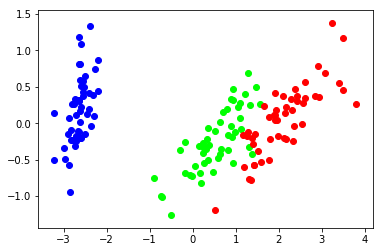

In [34]:
plot_func(x_projected[np.where(y==0)[0]],[0,0,1])
plot_func(x_projected[np.where(y==1)[0]],[0,1,0])
plot_func(x_projected[np.where(y==2)[0]],[1,0,0])

plt.show()

In [0]:
data = []
no_of_points = 50

for i in range(0,no_of_gaussians):
    data.extend(list(generate_multivariate_gaussian_data(mu[i],np.linalg.inv(sigma_inv[i]), no_of_points)))

data = np.array(data)

pca = decomposition.PCA(n_components=2)
pca.fit(data)
data = pca.transform(data)

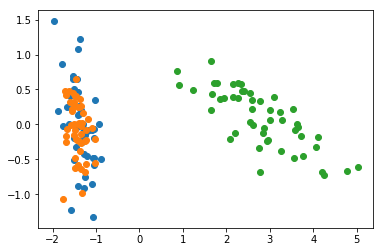

In [36]:
for i in range(0,no_of_gaussians):    
    arr=[1/(i+1),1/(i+2),1/(i+3)]    
    plot_func(data[i*no_of_points:(i+1)*no_of_points], random.shuffle(arr))

plt.show()